<a href="https://colab.research.google.com/github/Nikita-Gupta-19/Uber-Trip-Analysis/blob/main/Uber_Trip_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries and Load Data**

In [22]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.cluster import KMeans
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

# Load Dataset
df = pd.read_csv("Uber-Jan-Feb-FOIL.csv")
print("Data loaded successfully.")
df.head()

Data loaded successfully.


,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


# **Data Preprocessing**

In [23]:
# Data Cleaning
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Create time-based features
df['Hour'] = df['date'].dt.hour
df['Day'] = df['date'].dt.day
df['Weekday'] = df['date'].dt.dayofweek
df['Week'] = df['date'].dt.isocalendar().week
df['Month'] = df['date'].dt.month
df['Date_only'] = df['date'].dt.date  # Optional helper column

# Aggregate data by hour (if needed — or by day depending on frequency)
df_hourly = df.groupby(pd.Grouper(key='date', freq='H')).size().reset_index(name='Trip_Count')
df_hourly.set_index('date', inplace=True)

# Preview
df_hourly.head()

,Trip_Count
date,
2015-01-01 00:00:00,6
2015-01-01 01:00:00,0
2015-01-01 02:00:00,0
2015-01-01 03:00:00,0
2015-01-01 04:00:00,0


# **Exploratory Data Analysis (EDA)**

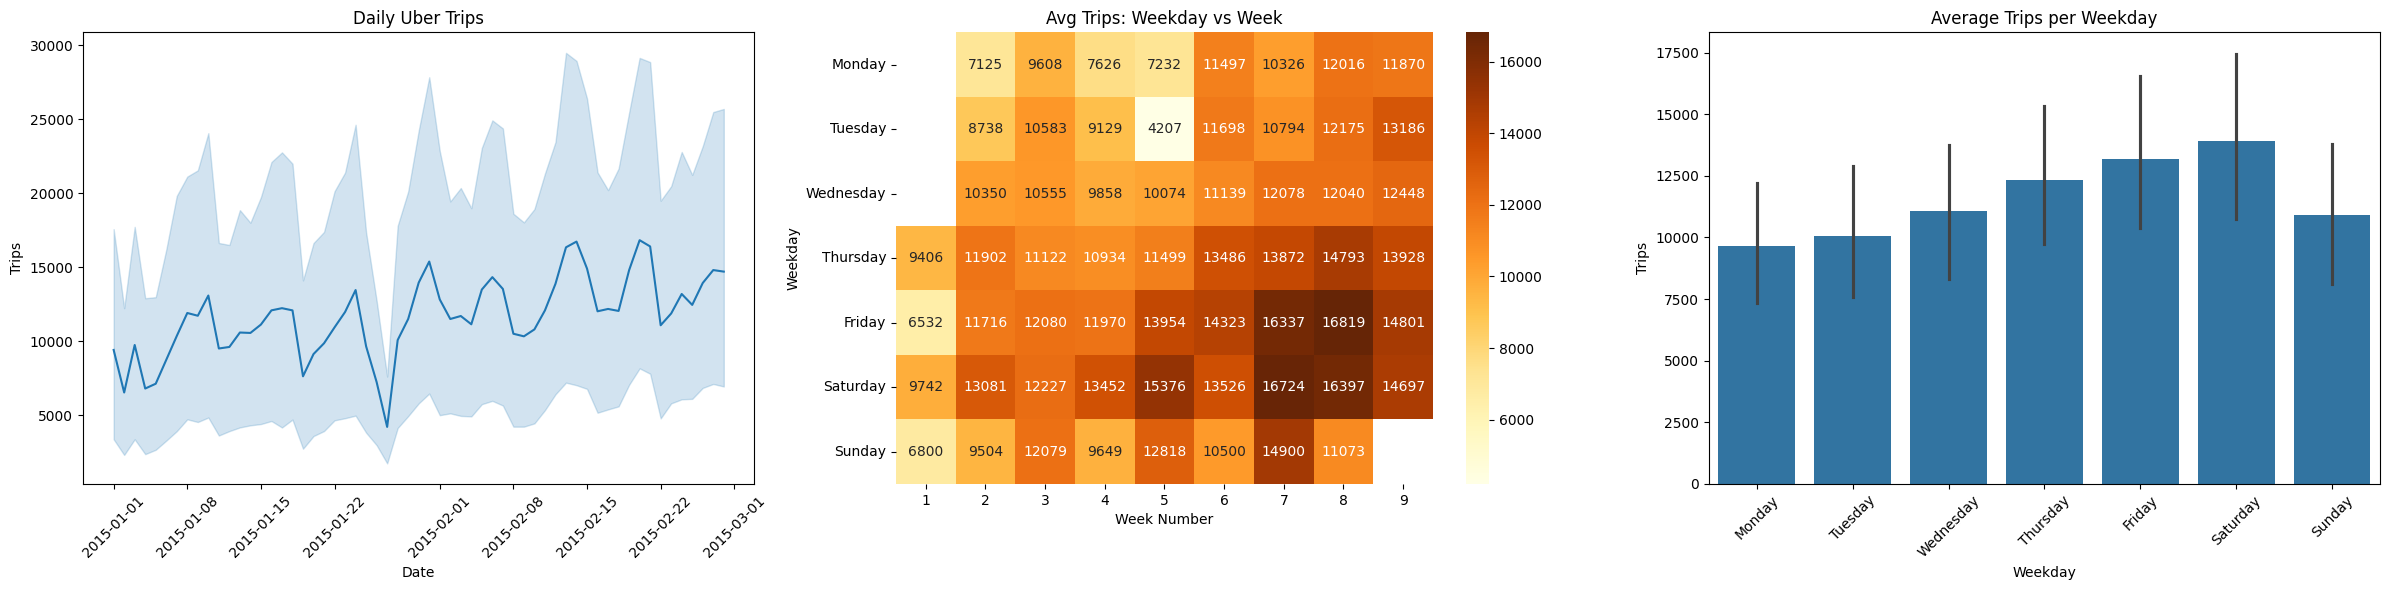

In [24]:
# Daily Uber Trips Plot

# Prepare data
df_daily = df.copy()
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily['Weekday'] = df_daily['date'].dt.day_name()
df_daily['Week'] = df_daily['date'].dt.isocalendar().week
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Pivot for heatmap
pivot = df_daily.pivot_table(index='Weekday', columns='Week', values='trips', aggfunc='mean')
pivot = pivot.reindex(weekday_order)
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# 1. Line Plot: Daily Trips
sns.lineplot(ax=axes[0], data=df_daily, x='date', y='trips')
axes[0].set_title("Daily Uber Trips")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Trips")
axes[0].tick_params(axis='x', rotation=45)

# 2. Heatmap: Weekday vs Week
sns.heatmap(pivot, cmap='YlOrBr', annot=True, fmt=".0f", ax=axes[1])
axes[1].set_title("Avg Trips: Weekday vs Week")
axes[1].set_xlabel("Week Number")
axes[1].set_ylabel("Weekday")

# 3. Bar Plot: Avg Trips per Weekday
sns.barplot(ax=axes[2], data=df_daily, x='Weekday', y='trips', order=weekday_order)
axes[2].set_title("Average Trips per Weekday")
axes[2].set_ylabel("Trips")
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# **Time Series Forecasting Data Prep**

In [25]:
# Time Series Lag Feature Creation
def create_lagged_features(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# Use a 24-hour lag window
window_size = 24
X, y = create_lagged_features(df_hourly['Trip_Count'].values, window_size)

# Split into train and test sets (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# **Forecasting with XGBoost, RF, GBTR**

In [26]:
# Model Training & Prediction
tscv = TimeSeriesSplit(n_splits=5)
seed = 42

# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=seed)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Random Forest
rf = RandomForestRegressor(random_state=seed)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# GBTR
gbtr = GradientBoostingRegressor(random_state=seed)
gbtr.fit(X_train, y_train)
gbtr_pred = gbtr.predict(X_test)

# **Model Evaluation**

In [27]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE for each model
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)
rf_mape = mean_absolute_percentage_error(y_test, rf_pred)
gbtr_mape = mean_absolute_percentage_error(y_test, gbtr_pred)

print(f"XGBoost MAPE: {xgb_mape:.2%}")
print(f"Random Forest MAPE: {rf_mape:.2%}")
print(f"GBTR MAPE: {gbtr_mape:.2%}")

# Small value to avoid division by zero
epsilon = 1e-10

# Ensemble weight calculation (safe)
weights = np.array([
    1 / (xgb_mape + epsilon),
    1 / (rf_mape + epsilon),
    1 / (gbtr_mape + epsilon)
])
weights = weights / weights.sum()

# Weighted ensemble prediction
ensemble_pred = (
    weights[0] * xgb_pred +
    weights[1] * rf_pred +
    weights[2] * gbtr_pred
)

# Evaluate ensemble
ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_pred)
print(f"Ensemble MAPE: {ensemble_mape:.2%}")

XGBoost MAPE: 2251142348800.00%
Random Forest MAPE: 0.00%
GBTR MAPE: 2883078117607.68%
Ensemble MAPE: 0.00%


# **Anomaly Detection**

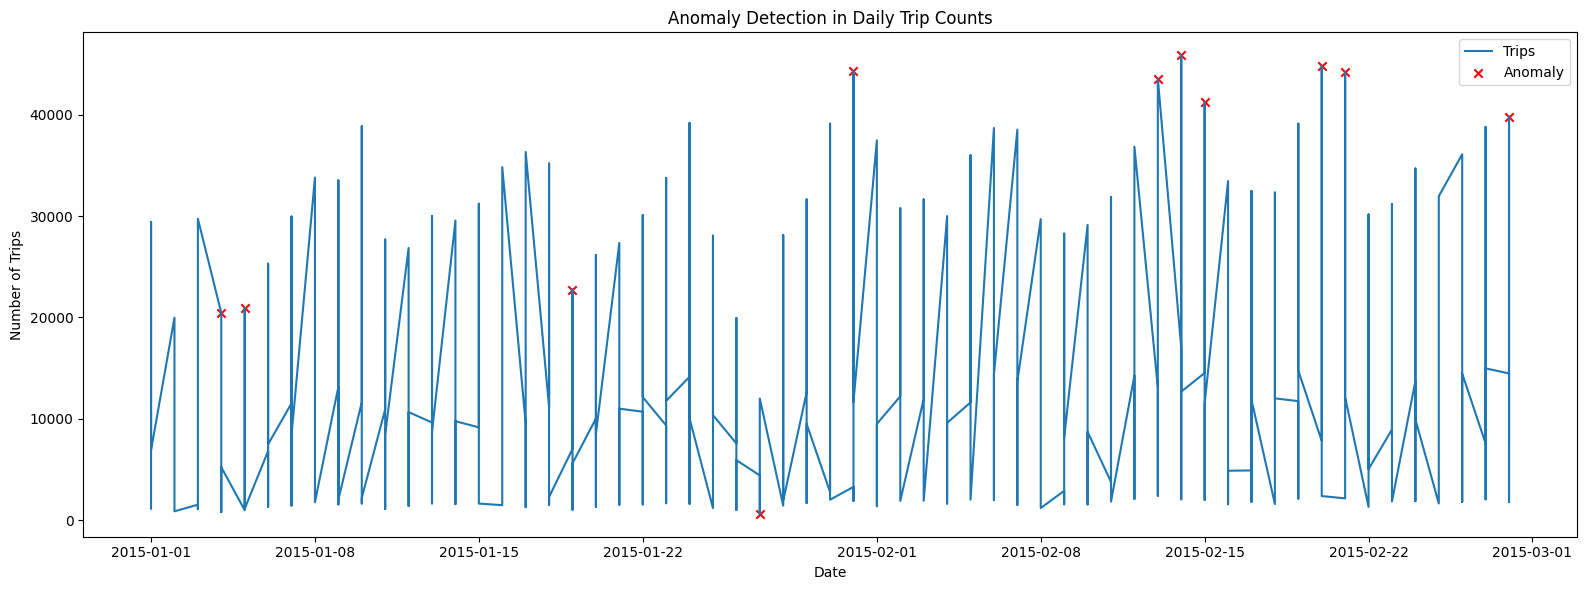

In [28]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Use actual trip counts per day
df_anomaly = df.copy()
df_anomaly['date'] = pd.to_datetime(df_anomaly['date'])
df_anomaly = df_anomaly[['date', 'trips']].copy()

# Fit Isolation Forest
model = IsolationForest(contamination=0.03, random_state=42)
df_anomaly['anomaly'] = model.fit_predict(df_anomaly[['trips']])

# Filter anomalies
anomalies = df_anomaly[df_anomaly['anomaly'] == -1]

# Plot
plt.figure(figsize=(16,6))
plt.plot(df_anomaly['date'], df_anomaly['trips'], label='Trips')
plt.scatter(anomalies['date'], anomalies['trips'], color='red', label='Anomaly', marker='x')
plt.title("Anomaly Detection in Daily Trip Counts")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.legend()
plt.tight_layout()
plt.show()

# **Rider Behavior Clustering**

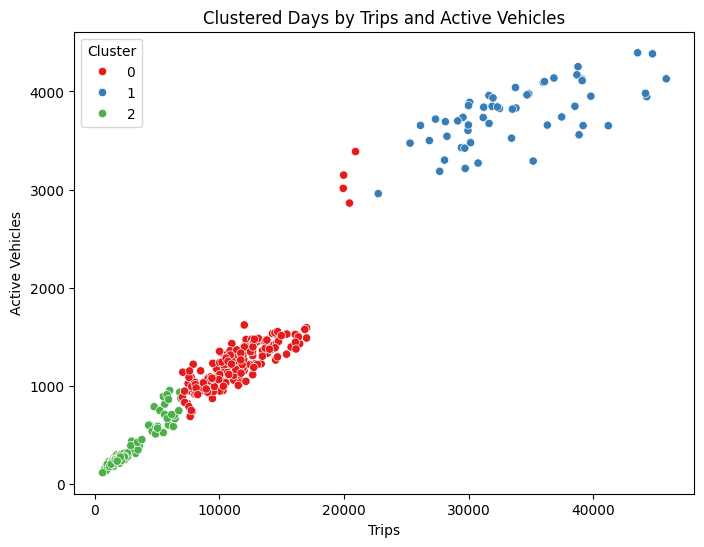

In [29]:
from sklearn.cluster import KMeans

# Choose meaningful features for clustering
features = df[['Weekday', 'trips', 'active_vehicles']]

# Apply clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(features)

# Visualize clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='trips', y='active_vehicles', hue='Cluster', palette='Set1')
plt.title("Clustered Days by Trips and Active Vehicles")
plt.xlabel("Trips")
plt.ylabel("Active Vehicles")
plt.show()

# **SQL Insights**

In [30]:
# Run SQL on Cleaned Data
conn = sqlite3.connect(":memory:")
df.to_sql("uber_trips", conn, index=False, if_exists='replace')

# Top 5 dispatching bases by total trips
query = """
SELECT dispatching_base_number AS Base, COUNT(*) AS Total_Trips
FROM uber_trips
GROUP BY dispatching_base_number
ORDER BY Total_Trips DESC
LIMIT 5;
"""

pd.read_sql(query, conn)

,Base,Total_Trips
0,B02765,59
1,B02764,59
2,B02682,59
3,B02617,59
4,B02598,59


# **SHAP for XGBoost Interpretability**

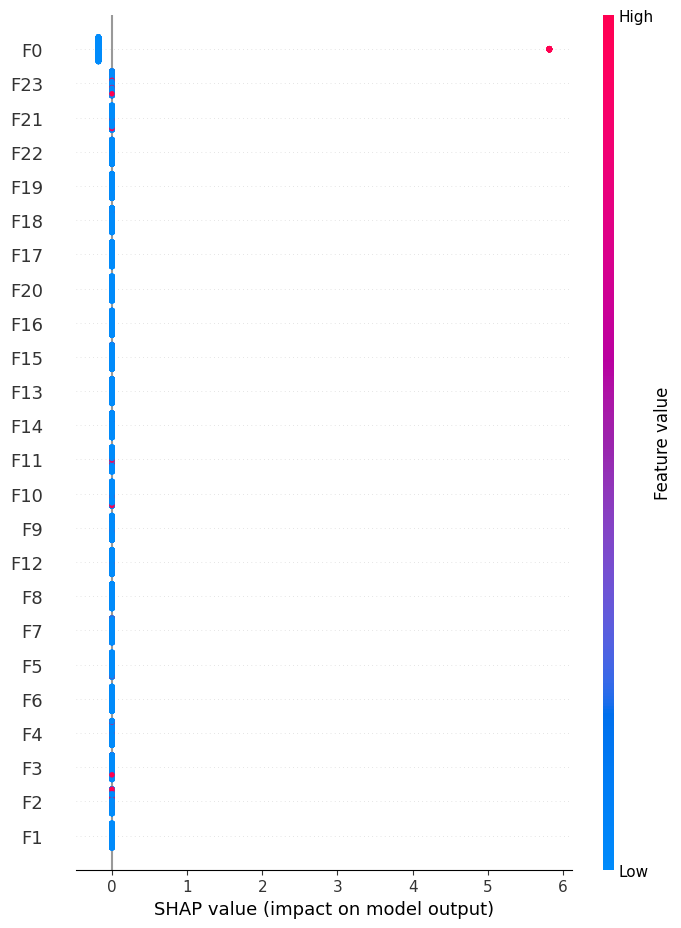

In [32]:
import shap
import pandas as pd

# Get feature names from model, or fallback to generic names
feature_names = xgb_model.get_booster().feature_names
if feature_names is None:
    feature_names = [f"F{i}" for i in range(X_train.shape[1])]

# Convert to DataFrame
X_train_df = pd.DataFrame(X_train, columns=feature_names)

# SHAP explainer
explainer = shap.Explainer(xgb_model, X_train_df)
shap_values = explainer(X_train_df)

# Plot all features
shap.plots.beeswarm(shap_values, max_display=X_train_df.shape[1])

# **Export Cleaned Data to CSV**

In [33]:
# Export the cleaned, feature-rich dataset

df.to_csv("Uber_analytics_data_final.csv", index=False)
from google.colab import files
files.download("Uber_analytics_data_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>